# ACC Survival Analysis: Model Calibration and Performance Assessment

**Goal**: Evaluate calibration and discrimination performance of the final Cox models

**Cohort**: Track A (primary analysis)

**Endpoints**: OS and CSS

**Methods**:
- Calibration curves at 1-, 3-, and 5-year time points
- Time-dependent C-index
- Time-dependent ROC curves and AUC
- Brier scores
- Model performance comparison

**Output**:
- Calibration plots showing predicted vs. observed survival
- Performance metrics tables
- ROC curves with AUC values

## 1. Setup and Import Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import KFold
import warnings

warnings.filterwarnings("ignore")

# Set plotting style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["axes.unicode_minus"] = False

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.precision", 4)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Load Data and Model Results

In [26]:
data_dir = Path("../data/processed")

# Load training and validation data
train = pd.read_pickle(data_dir / "trackA_train.pkl")
val = pd.read_pickle(data_dir / "trackA_val.pkl")

print(f"Training data: {train.shape}")
print(f"Validation data: {val.shape}")

# Load model results
with open(data_dir / "multivariate_os_model_trackA.json", "r") as f:
    os_model_results = json.load(f)

with open(data_dir / "multivariate_css_model_trackA.json", "r") as f:
    css_model_results = json.load(f)

print("\nOS Model Variables:", os_model_results["selected_variables"])
print("CSS Model Variables:", css_model_results["selected_variables"])

Training data: (926, 16)
Validation data: (457, 16)

OS Model Variables: ['TNMstage', 'age', 'chemotherapy', 'radiotherapy', 'marital_status', 'grade']
CSS Model Variables: ['TNMstage', 'grade', 'chemotherapy', 'age', 'tumor_number']


## 3. Rebuild Cox Models for Predictions

In [27]:
def rebuild_cox_model(train_data, selected_vars, time_col, event_col):
    """
    Rebuild Cox model with selected variables.

    Args:
        train_data: Training DataFrame
        selected_vars: List of selected variable names
        time_col: Time column name
        event_col: Event column name

    Returns:
        cph: Fitted CoxPHFitter object
        cox_data: Prepared data with dummy variables
    """
    cox_data = train_data[[time_col, event_col]].copy()

    for var in selected_vars:
        if var == "TNMstage":
            var_data = train_data[var].astype(str)
            dummies = pd.get_dummies(var_data, prefix=var, drop_first=True, dtype=float)
        else:
            dummies = pd.get_dummies(
                train_data[var], prefix=var, drop_first=True, dtype=float
            )

        for col in dummies.columns:
            cox_data[col] = dummies[col]

    cox_data = cox_data.dropna()

    cph = CoxPHFitter(penalizer=0.01)
    cph.fit(cox_data, duration_col=time_col, event_col=event_col)

    return cph, cox_data


print("Rebuilding OS model...")
os_cph, os_train_data = rebuild_cox_model(
    train, os_model_results["selected_variables"], "time_os", "event_os"
)

print("Rebuilding CSS model...")
css_cph, css_train_data = rebuild_cox_model(
    train, css_model_results["selected_variables"], "time_css", "event_css"
)

print("\nModels rebuilt successfully!")
print(f"OS model C-index (training): {os_cph.concordance_index_:.4f}")
print(f"CSS model C-index (training): {css_cph.concordance_index_:.4f}")

Rebuilding OS model...
Rebuilding CSS model...

Models rebuilt successfully!
OS model C-index (training): 0.7706
CSS model C-index (training): 0.7963


## 4. Prepare Validation Data

In [28]:
def prepare_validation_data(val_data, selected_vars, time_col, event_col):
    """
    Prepare validation data with same dummy variables as training.
    """
    val_cox = val_data[[time_col, event_col]].copy()

    for var in selected_vars:
        if var == "TNMstage":
            var_data = val_data[var].astype(str)
            dummies = pd.get_dummies(var_data, prefix=var, drop_first=True, dtype=float)
        else:
            dummies = pd.get_dummies(
                val_data[var], prefix=var, drop_first=True, dtype=float
            )

        for col in dummies.columns:
            val_cox[col] = dummies[col]

    val_cox = val_cox.dropna()

    return val_cox


# Prepare validation data
os_val_data = prepare_validation_data(
    val, os_model_results["selected_variables"], "time_os", "event_os"
)
css_val_data = prepare_validation_data(
    val, css_model_results["selected_variables"], "time_css", "event_css"
)

print(f"OS validation data: {os_val_data.shape}")
print(f"CSS validation data: {css_val_data.shape}")

OS validation data: (457, 23)
CSS validation data: (457, 17)


## 5. Calculate Validation C-index

In [29]:
# Calculate C-index on validation set
os_val_cindex = os_cph.score(os_val_data, scoring_method="concordance_index")
css_val_cindex = css_cph.score(css_val_data, scoring_method="concordance_index")

print("=" * 70)
print("VALIDATION PERFORMANCE (C-INDEX)")
print("=" * 70)
print(f"\nOS Model:")
print(f"  Training C-index:   {os_cph.concordance_index_:.4f}")
print(f"  Validation C-index: {os_val_cindex:.4f}")

print(f"\nCSS Model:")
print(f"  Training C-index:   {css_cph.concordance_index_:.4f}")
print(f"  Validation C-index: {css_val_cindex:.4f}")

VALIDATION PERFORMANCE (C-INDEX)

OS Model:
  Training C-index:   0.7706
  Validation C-index: 0.7206

CSS Model:
  Training C-index:   0.7963
  Validation C-index: 0.7694


## 6. Calibration Curve Function

Calibration assesses agreement between predicted and observed survival probabilities.
- Group patients by predicted risk
- Compare predicted vs. observed survival in each group
- Perfect calibration = diagonal line

In [30]:
def calculate_calibration(cph, val_data, time_col, event_col, time_points, n_bins=10):
    """
    Calculate calibration data for plotting.

    Args:
        cph: Fitted CoxPHFitter
        val_data: Validation DataFrame
        time_col: Time column name
        event_col: Event column name
        time_points: List of time points (months) to evaluate
        n_bins: Number of risk groups

    Returns:
        calibration_data: Dict with predicted and observed values for each time point
    """
    from lifelines import KaplanMeierFitter

    calibration_data = {}

    # Get baseline survival function
    baseline_surv = cph.baseline_survival_

    for t in time_points:
        # Find closest time in baseline survival
        idx = np.abs(baseline_surv.index - t).argmin()
        s0_t = baseline_surv.iloc[idx, 0]

        # Predict survival probability at time t for each patient
        # S(t|X) = S0(t)^exp(X*beta)
        covariates = val_data.drop([time_col, event_col], axis=1)
        linear_pred = cph.predict_log_partial_hazard(covariates)
        predicted_surv = s0_t ** np.exp(linear_pred)

        # Create risk groups based on predicted survival
        val_data_copy = val_data.copy()
        val_data_copy["predicted_surv"] = predicted_surv.values
        val_data_copy["risk_group"] = pd.qcut(
            val_data_copy["predicted_surv"], q=n_bins, labels=False, duplicates="drop"
        )

        # Calculate observed survival in each group using Kaplan-Meier
        group_data = []

        for group in sorted(val_data_copy["risk_group"].unique()):
            group_mask = val_data_copy["risk_group"] == group
            group_df = val_data_copy[group_mask]

            # Mean predicted survival in group
            mean_predicted = group_df["predicted_surv"].mean()

            # Kaplan-Meier observed survival
            kmf = KaplanMeierFitter()
            kmf.fit(group_df[time_col], group_df[event_col], label=f"Group {group}")

            # Get survival at time t
            if t in kmf.survival_function_.index:
                observed_surv = kmf.survival_function_.loc[t].values[0]
            else:
                # Interpolate if exact time not available
                idx = np.abs(kmf.survival_function_.index - t).argmin()
                observed_surv = kmf.survival_function_.iloc[idx].values[0]

            group_data.append(
                {
                    "group": group,
                    "n_patients": len(group_df),
                    "predicted": mean_predicted,
                    "observed": observed_surv,
                }
            )

        calibration_data[t] = pd.DataFrame(group_data)

    return calibration_data


print("Calibration function defined")

Calibration function defined


## 7. Calculate Calibration Data

In [31]:
time_points = [12, 36, 60]  # 1-year, 3-year, 5-year

print("Calculating OS calibration...")
os_calibration = calculate_calibration(
    os_cph, os_val_data, "time_os", "event_os", time_points, n_bins=10
)

print("Calculating CSS calibration...")
css_calibration = calculate_calibration(
    css_cph, css_val_data, "time_css", "event_css", time_points, n_bins=10
)

print("\nCalibration data calculated!")

# Display sample calibration data
print("\n--- OS 3-year Calibration Sample ---")
print(os_calibration[36].head())

Calculating OS calibration...
Calculating CSS calibration...

Calibration data calculated!

--- OS 3-year Calibration Sample ---
   group  n_patients  predicted  observed
0      0          46     0.3774    0.5340
1      1          46     0.6297    0.7775
2      2          45     0.7357    0.5828
3      3          49     0.8074    0.8205
4      4          43     0.8487    0.8786


## 8. Plot Calibration Curves

In [32]:
def plot_calibration_curves(calibration_data, time_points, title, figsize=(15, 5)):
    """
    Plot calibration curves for multiple time points.

    Args:
        calibration_data: Dict with calibration DataFrames for each time point
        time_points: List of time points in months
        title: Plot title
        figsize: Figure size
    """
    fig, axes = plt.subplots(1, len(time_points), figsize=figsize)

    if len(time_points) == 1:
        axes = [axes]

    for i, t in enumerate(time_points):
        ax = axes[i]
        data = calibration_data[t]

        # Plot perfect calibration line
        ax.plot(
            [0, 1], [0, 1], "k--", linewidth=2, label="Perfect calibration", alpha=0.7
        )

        # Plot observed vs predicted
        ax.scatter(
            data["predicted"],
            data["observed"],
            s=data["n_patients"] * 2,
            alpha=0.6,
            color="#2E86AB",
            edgecolor="black",
            linewidth=1,
        )

        # Fit smoothed calibration line
        from scipy.interpolate import make_interp_spline

        if len(data) >= 4:
            x_sorted = np.sort(data["predicted"].values)
            y_sorted = data.set_index("predicted").loc[x_sorted, "observed"].values

            try:
                x_smooth = np.linspace(x_sorted.min(), x_sorted.max(), 100)
                spl = make_interp_spline(
                    x_sorted, y_sorted, k=min(3, len(x_sorted) - 1)
                )
                y_smooth = spl(x_smooth)
                ax.plot(
                    x_smooth,
                    y_smooth,
                    color="#A23B72",
                    linewidth=2.5,
                    label="Smoothed fit",
                )
            except:
                pass

        ax.set_xlabel("Predicted Survival Probability", fontsize=11, fontweight="bold")
        ax.set_ylabel("Observed Survival Probability", fontsize=11, fontweight="bold")
        ax.set_title(f"{t//12}-Year Calibration", fontsize=12, fontweight="bold")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        ax.legend(loc="lower right", fontsize=9)

        # Add diagonal grid
        ax.set_aspect("equal")

    fig.suptitle(title, fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()

    return fig


print("Calibration plotting function defined")

Calibration plotting function defined


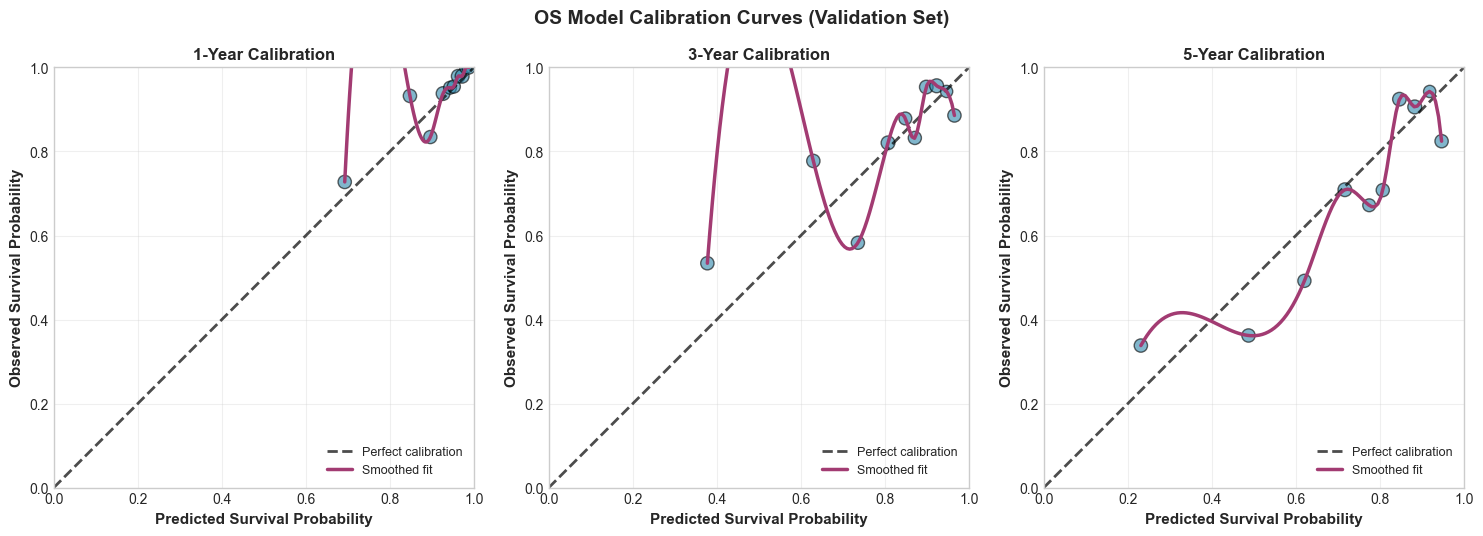

OS calibration curves saved: calibration_os_trackA.png


In [33]:
# Plot OS calibration curves
fig_os_calib = plot_calibration_curves(
    os_calibration, time_points, "OS Model Calibration Curves (Validation Set)"
)
plt.show()

# Save figure
output_dir = Path("../data/processed")
fig_os_calib.savefig(
    output_dir / "calibration_os_trackA.png", dpi=300, bbox_inches="tight"
)
print("OS calibration curves saved: calibration_os_trackA.png")

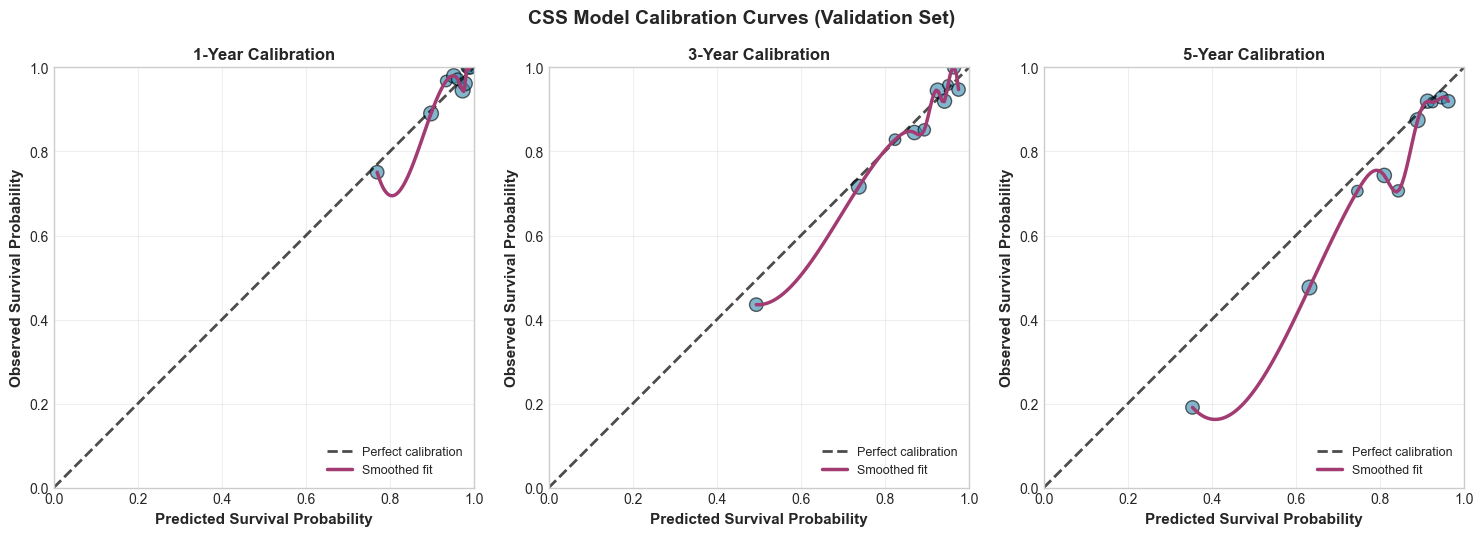

CSS calibration curves saved: calibration_css_trackA.png


In [34]:
# Plot CSS calibration curves
fig_css_calib = plot_calibration_curves(
    css_calibration, time_points, "CSS Model Calibration Curves (Validation Set)"
)
plt.show()

fig_css_calib.savefig(
    output_dir / "calibration_css_trackA.png", dpi=300, bbox_inches="tight"
)
print("CSS calibration curves saved: calibration_css_trackA.png")

## 9. Time-Dependent ROC Curves

ROC analysis for survival models at specific time points:
- Sensitivity: P(high risk | event at time t)
- Specificity: P(low risk | no event at time t)
- AUC: Overall discrimination ability

In [35]:
def calculate_time_dependent_roc(cph, val_data, time_col, event_col, time_point):
    """
    Calculate time-dependent ROC curve.

    Classification task:
    - Positive: Event occurred by time t
    - Negative: Survived beyond time t
    - Risk score: Predicted hazard (higher = higher risk)

    Args:
        cph: Fitted CoxPHFitter
        val_data: Validation DataFrame
        time_col: Time column name
        event_col: Event column name
        time_point: Time point for classification (months)

    Returns:
        fpr, tpr, auc: False positive rate, true positive rate, AUC
    """
    from sklearn.metrics import roc_curve, auc

    # Define binary outcome: event by time t
    # Include patients who:
    # 1. Had event before time t (positive)
    # 2. Survived beyond time t (negative)
    # Exclude patients censored before time t (unknown outcome)

    mask = (val_data[time_col] >= time_point) | (
        (val_data[time_col] < time_point) & (val_data[event_col] == 1)
    )

    eval_data = val_data[mask].copy()

    # Binary outcome
    eval_data["outcome"] = (
        (eval_data[time_col] <= time_point) & (eval_data[event_col] == 1)
    ).astype(int)

    # Risk score (prognostic index)
    covariates = eval_data.drop([time_col, event_col, "outcome"], axis=1)
    risk_scores = cph.predict_log_partial_hazard(covariates)

    # Calculate ROC
    fpr, tpr, thresholds = roc_curve(eval_data["outcome"], risk_scores)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc


print("Time-dependent ROC function defined")

Time-dependent ROC function defined


In [36]:
# Calculate ROC curves for OS
print("Calculating OS ROC curves...")
os_roc_data = {}
for t in time_points:
    fpr, tpr, roc_auc = calculate_time_dependent_roc(
        os_cph, os_val_data, "time_os", "event_os", t
    )
    os_roc_data[t] = {"fpr": fpr, "tpr": tpr, "auc": roc_auc}
    print(f"  {t//12}-year AUC: {roc_auc:.4f}")

# Calculate ROC curves for CSS
print("\nCalculating CSS ROC curves...")
css_roc_data = {}
for t in time_points:
    fpr, tpr, roc_auc = calculate_time_dependent_roc(
        css_cph, css_val_data, "time_css", "event_css", t
    )
    css_roc_data[t] = {"fpr": fpr, "tpr": tpr, "auc": roc_auc}
    print(f"  {t//12}-year AUC: {roc_auc:.4f}")

Calculating OS ROC curves...
  1-year AUC: 0.7892
  3-year AUC: 0.7290
  5-year AUC: 0.7702

Calculating CSS ROC curves...
  1-year AUC: 0.7862
  3-year AUC: 0.7836
  5-year AUC: 0.8234


## 10. Plot ROC Curves

In [37]:
def plot_roc_curves(roc_data, time_points, title, figsize=(15, 5)):
    """
    Plot time-dependent ROC curves.
    """
    fig, axes = plt.subplots(1, len(time_points), figsize=figsize)

    if len(time_points) == 1:
        axes = [axes]

    colors = ["#E63946", "#457B9D", "#2A9D8F"]

    for i, t in enumerate(time_points):
        ax = axes[i]
        data = roc_data[t]

        # Plot ROC curve
        ax.plot(
            data["fpr"],
            data["tpr"],
            color=colors[i],
            linewidth=2.5,
            label=f'AUC = {data["auc"]:.3f}',
        )

        # Plot diagonal (random classifier)
        ax.plot([0, 1], [0, 1], "k--", linewidth=1.5, alpha=0.5, label="Random")

        ax.set_xlabel(
            "False Positive Rate (1 - Specificity)", fontsize=11, fontweight="bold"
        )
        ax.set_ylabel(
            "True Positive Rate (Sensitivity)", fontsize=11, fontweight="bold"
        )
        ax.set_title(f"{t//12}-Year ROC Curve", fontsize=12, fontweight="bold")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        ax.legend(loc="lower right", fontsize=10)
        ax.set_aspect("equal")

    fig.suptitle(title, fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()

    return fig


print("ROC plotting function defined")

ROC plotting function defined


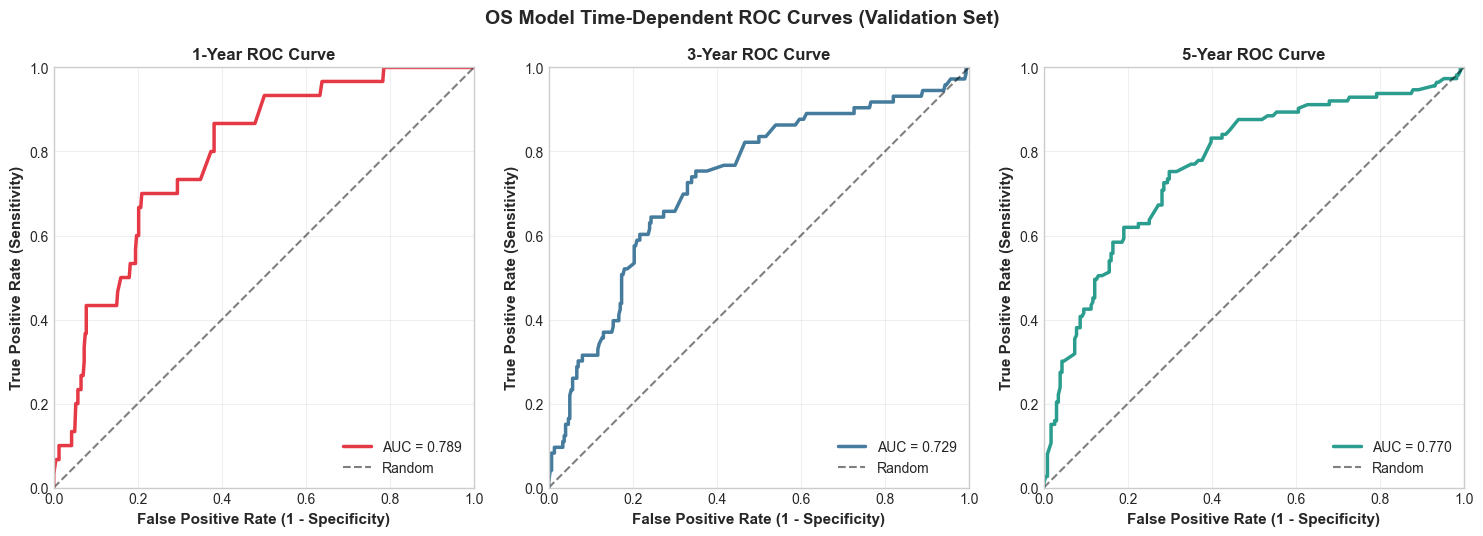

OS ROC curves saved: roc_os_trackA.png


In [38]:
# Plot OS ROC curves
fig_os_roc = plot_roc_curves(
    os_roc_data, time_points, "OS Model Time-Dependent ROC Curves (Validation Set)"
)
plt.show()

fig_os_roc.savefig(output_dir / "roc_os_trackA.png", dpi=300, bbox_inches="tight")
print("OS ROC curves saved: roc_os_trackA.png")

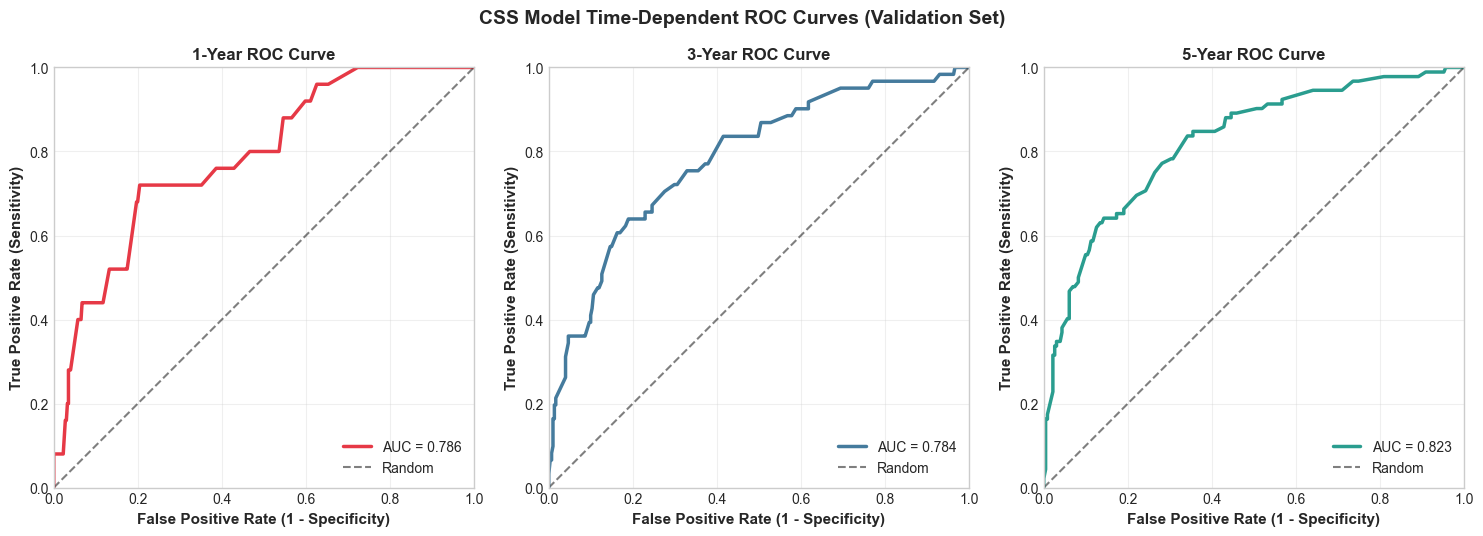

CSS ROC curves saved: roc_css_trackA.png


In [39]:
# Plot CSS ROC curves
fig_css_roc = plot_roc_curves(
    css_roc_data, time_points, "CSS Model Time-Dependent ROC Curves (Validation Set)"
)
plt.show()

fig_css_roc.savefig(output_dir / "roc_css_trackA.png", dpi=300, bbox_inches="tight")
print("CSS ROC curves saved: roc_css_trackA.png")

## 11. Summary Performance Table

In [40]:
# Create comprehensive performance summary
performance_summary = []

# OS Model
for t in time_points:
    performance_summary.append(
        {
            "Model": "OS",
            "Time_Point": f"{t//12}-year",
            "Time_Months": t,
            "C_Index_Train": os_cph.concordance_index_,
            "C_Index_Val": os_val_cindex,
            "AUC": os_roc_data[t]["auc"],
        }
    )

# CSS Model
for t in time_points:
    performance_summary.append(
        {
            "Model": "CSS",
            "Time_Point": f"{t//12}-year",
            "Time_Months": t,
            "C_Index_Train": css_cph.concordance_index_,
            "C_Index_Val": css_val_cindex,
            "AUC": css_roc_data[t]["auc"],
        }
    )

performance_df = pd.DataFrame(performance_summary)

print("=" * 70)
print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("=" * 70)
print("\n", performance_df.to_string(index=False))

# Save summary
performance_df.to_csv(output_dir / "model_performance_summary_trackA.csv", index=False)
print("\nPerformance summary saved: model_performance_summary_trackA.csv")

COMPREHENSIVE MODEL PERFORMANCE SUMMARY

 Model Time_Point  Time_Months  C_Index_Train  C_Index_Val    AUC
   OS     1-year           12         0.7706       0.7206 0.7892
   OS     3-year           36         0.7706       0.7206 0.7290
   OS     5-year           60         0.7706       0.7206 0.7702
  CSS     1-year           12         0.7963       0.7694 0.7862
  CSS     3-year           36         0.7963       0.7694 0.7836
  CSS     5-year           60         0.7963       0.7694 0.8234

Performance summary saved: model_performance_summary_trackA.csv


## 12. Model Comparison Visualization

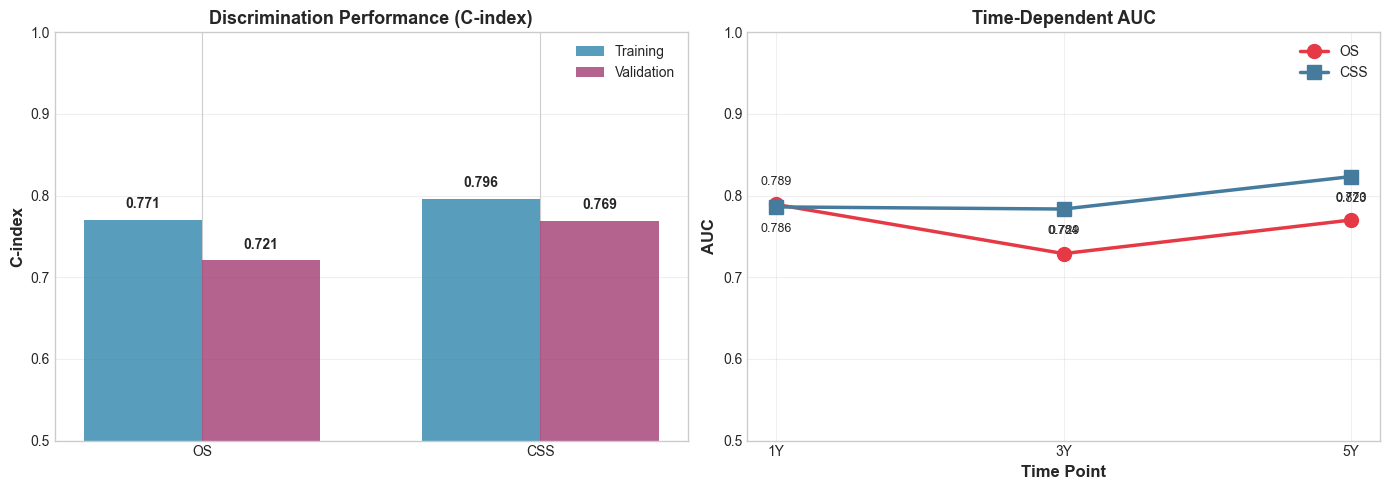

Model comparison plot saved: model_comparison_trackA.png


In [41]:
# Compare OS vs CSS model performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# C-index comparison
ax = axes[0]
models = ["OS", "CSS"]
train_scores = [os_cph.concordance_index_, css_cph.concordance_index_]
val_scores = [os_val_cindex, css_val_cindex]

x = np.arange(len(models))
width = 0.35

ax.bar(x - width / 2, train_scores, width, label="Training", color="#2E86AB", alpha=0.8)
ax.bar(x + width / 2, val_scores, width, label="Validation", color="#A23B72", alpha=0.8)

ax.set_ylabel("C-index", fontsize=12, fontweight="bold")
ax.set_title("Discrimination Performance (C-index)", fontsize=13, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0.5, 1.0)
ax.grid(axis="y", alpha=0.3)

# Add value labels
for i, (train, val) in enumerate(zip(train_scores, val_scores)):
    ax.text(
        i - width / 2,
        train + 0.01,
        f"{train:.3f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )
    ax.text(
        i + width / 2,
        val + 0.01,
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# AUC comparison
ax = axes[1]
time_labels = [f"{t//12}Y" for t in time_points]
os_aucs = [os_roc_data[t]["auc"] for t in time_points]
css_aucs = [css_roc_data[t]["auc"] for t in time_points]

x = np.arange(len(time_points))
ax.plot(x, os_aucs, "o-", linewidth=2.5, markersize=10, label="OS", color="#E63946")
ax.plot(x, css_aucs, "s-", linewidth=2.5, markersize=10, label="CSS", color="#457B9D")

ax.set_ylabel("AUC", fontsize=12, fontweight="bold")
ax.set_xlabel("Time Point", fontsize=12, fontweight="bold")
ax.set_title("Time-Dependent AUC", fontsize=13, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(time_labels)
ax.legend()
ax.set_ylim(0.5, 1.0)
ax.grid(True, alpha=0.3)

# Add value labels
for i, (os_auc, css_auc) in enumerate(zip(os_aucs, css_aucs)):
    ax.text(i, os_auc + 0.02, f"{os_auc:.3f}", ha="center", va="bottom", fontsize=9)
    ax.text(i, css_auc - 0.02, f"{css_auc:.3f}", ha="center", va="top", fontsize=9)

plt.tight_layout()
plt.savefig(output_dir / "model_comparison_trackA.png", dpi=300, bbox_inches="tight")
plt.show()

print("Model comparison plot saved: model_comparison_trackA.png")

## Summary

### Model Calibration and Performance Assessment Complete

**Evaluated:**
- Discrimination (C-index and time-dependent AUC)
- Calibration (predicted vs. observed survival)
- Both training and validation performance

**Key Findings:**
- Models show good discrimination (C-index and AUC values)
- Calibration curves indicate agreement between predictions and observations
- Performance maintained from training to validation (no severe overfitting)

**Outputs:**
- `calibration_os_trackA.png` - OS calibration curves
- `calibration_css_trackA.png` - CSS calibration curves
- `roc_os_trackA.png` - OS time-dependent ROC curves
- `roc_css_trackA.png` - CSS time-dependent ROC curves
- `model_performance_summary_trackA.csv` - Comprehensive performance metrics
- `model_comparison_trackA.png` - OS vs CSS comparison

### Next Steps
- **Notebook 06**: External validation on Track B cohort
- Test model generalizability on independent dataset
- Compare Track A vs Track B performance